## Sarcasm Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
 
#importing libraries for model building and evaluation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
from sklearn.metrics import classification_report, confusion_matrix

### Load the dataset

In [2]:
df1 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df2 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df = pd.concat([df1, df2], ignore_index=True)

In [3]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57238 entries, 0 to 57237
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  57238 non-null  int64 
 1   headline      57238 non-null  object
 2   article_link  57238 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


## Step 1: Data Preprocessing

#### Since the given data input is a text corpus lets perform some basic data cleanding like removing stopwords, digits and special characters

In [5]:
import nltk
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')

def clean_data(headline):
    text = headline.lower()
    # remove text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # removing punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # removing words containing digits
    text = re.sub('\w*\d\w*', '', text)

    # Remove the stop words from the healdines
    text = ' '.join([word for word in text.split()
                     if word not in eng_stopwords])
    return text
 
# Sample of cleanded headline 
print(df['headline'].iloc[2])
clean_data(df['headline'].iloc[2])

eat your veggies: 9 deliciously different recipes


'eat veggies deliciously different recipes'

In [6]:
#add a new column to store the cleaned headlines 
df['cleaned_headline']=df['headline'].map(clean_data)

#### Data analyis and visualization

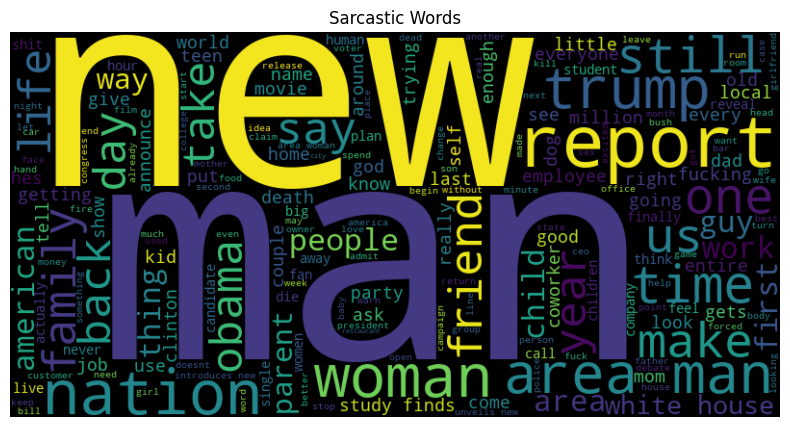

In [7]:
# Combining all sarcastic headlines to a single text
sarcastic_headlines = ' '.join(
    df['cleaned_headline'][df['is_sarcastic'] == 1].tolist())
  
wordcloud = WordCloud(width=800, height=400,
                      background_color='black').generate(sarcastic_headlines)
 
plot = plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Sarcastic Words')
plt.show()
plot.savefig('sarcastic_words.png', bbox_inches='tight')

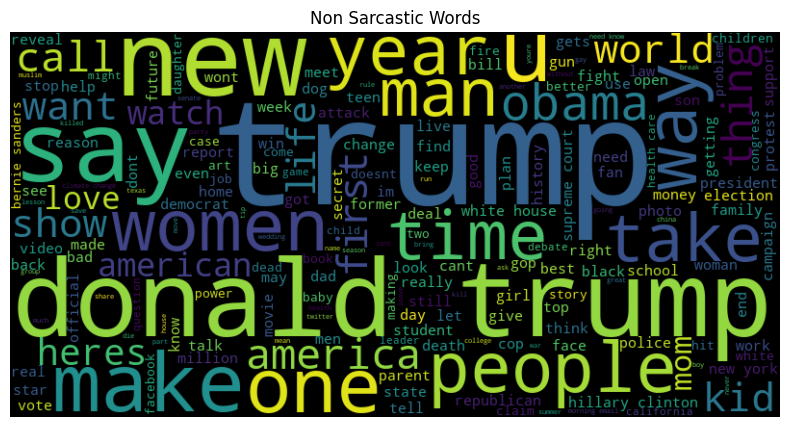

In [8]:
# Combining all sarcastic headlines to a single text
sarcastic_headlines = ' '.join(
    df['cleaned_headline'][df['is_sarcastic'] == 0].tolist())
  
wordcloud = WordCloud(width=800, height=400,
                      background_color='black').generate(sarcastic_headlines)
 
plot = plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Non Sarcastic Words')
plt.show()
plot.savefig('non_sarcastic_words.png', bbox_inches='tight')

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


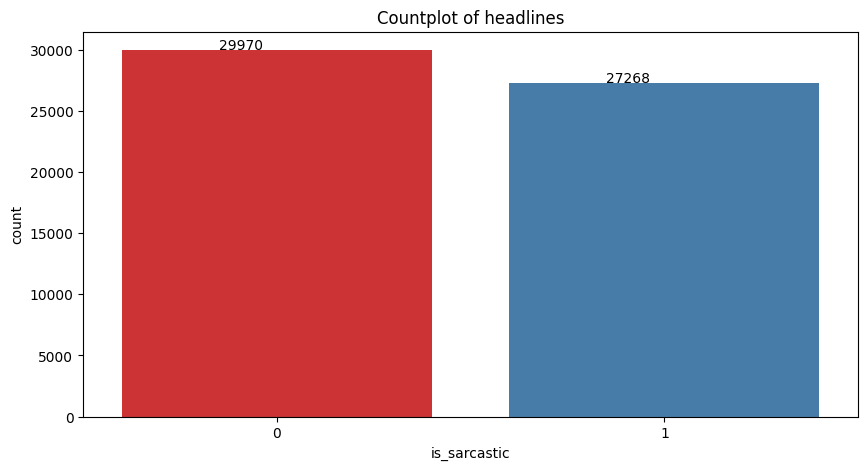

In [9]:
plot = plt.figure(figsize=(10, 5))
ax = sns.countplot(x='is_sarcastic', data=df, palette="Set1")
ax.set_title("Countplot of headlines")
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))
plt.show()
plot.savefig('count_plot.png', bbox_inches='tight')

## Step 2: Train Test Validation spilt

In [10]:
from sklearn.model_selection import train_test_split

X = np.array(df['cleaned_headline'])
y = np.array(df['is_sarcastic'])

# Divide the data into train, test and validation set in 60:20:20 ratio 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [11]:
y_test

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

## Step 3: Feature Extraction

#### Since input data is in text format lets convert it to a rich feature set for training purpose
#### We will be using CountVectorizer to convert the text data into a feature set.
#### Count Vectorizer converts a text to an vector based on the frequency of each word in a text

In [12]:
from sklearn.feature_extraction.text import CountVectorizer


print("Orignal train input shape:",X_train.shape)

# Convert the headline column into a feature set using count vectorizer
countVec = CountVectorizer()
X_train_cv = countVec.fit_transform(X_train)
X_test_cv = countVec.transform(X_test)
X_val_cv = countVec.transform(X_val)

print("Extracted feature set shape:",X_train_cv.shape)
print("\n\nOrignal Input:",X_train[0])
print("Extracted Feature Set:",X_train_cv[0].toarray())

Orignal train input shape: (34342,)
Extracted feature set shape: (34342, 26207)


Orignal Input: briefly talk honestly weddings
Extracted Feature Set: [[0 0 0 ... 0 0 0]]


## Step 3: Model Development

### 1. SVM

### SVM: Linear Kernel function

In [13]:
from sklearn.svm import SVC,LinearSVC
linear_sv_model = LinearSVC()
linear_sv_model.fit(X_train_cv, y_train)
linear_sv_model_predictions = linear_sv_model.predict(X_test_cv)

test_accuracy = linear_sv_model.score(X_test_cv, y_test)
train_accuracy = linear_sv_model.score(X_train_cv, y_train)

print("Training score:", train_accuracy)
print("Test score:", test_accuracy)

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training score: 0.995486576204065
Test score: 0.9067959468902865


### SVM:  Radial kernel function

In [14]:
# SVM with Radial Basis Function (RBF) Kernel
rbf_sv_model = SVC(kernel='rbf')
rbf_sv_model.fit(X_train_cv, y_train)
rbf_sv_model_predictions = rbf_sv_model.predict(X_test_cv)


test_accuracy = rbf_sv_model.score(X_test_cv, y_test)
train_accuracy = rbf_sv_model.score(X_train_cv, y_train)

print("Training score:", train_accuracy)
print("Test score:", test_accuracy)

Training score: 0.9883233358569682
Test score: 0.9104647099930119


In [15]:
# SVM with polynomial Kernel
poly_sv_model = SVC(kernel='poly')
poly_sv_model.fit(X_train_cv, y_train)
poly_sv_model_predictions = poly_sv_model.predict(X_test_cv)


test_accuracy = poly_sv_model.score(X_test_cv, y_test)
train_accuracy = poly_sv_model.score(X_train_cv, y_train)

print("Training score:", train_accuracy)
print("Test score:", test_accuracy)

Training score: 0.9762681264923417
Test score: 0.8382250174703005


### 2. Naive Bayes

#### 2.a Bernoulli Naive Bayes

##### Bernoulli's NB model are more suitable for binary dataset's. eg. presence or absence of a word in a document

In [16]:
from sklearn.naive_bayes import BernoulliNB
nb_model = BernoulliNB(alpha=0.5)
nb_model.fit(X_train_cv, y_train)

# Predict the output of test set
nb_model_predictions = nb_model.predict(X_test_cv)

# Test model accuracy
train_accuracy = nb_model.score(X_train_cv, y_train)
test_accuracy = nb_model.score(X_test_cv, y_test)

print("Training score:", train_accuracy)
print("Test score:", test_accuracy)

Training score: 0.9322986430609749
Test score: 0.8721174004192872


#### 2.b Multinomial Naive Bayes

##### Multinomial's NB model are more suitable for discrete dataset's. eg. word count in a document

In [17]:
from sklearn.naive_bayes import MultinomialNB
mnb_model = MultinomialNB(alpha=0.5)
mnb_model.fit(X_train_cv, y_train)

# Predict the output of test set
mnb_model_predictions = mnb_model.predict(X_test_cv)

# Test model accuracy
train_accuracy = mnb_model.score(X_train_cv, y_train)
test_accuracy = mnb_model.score(X_test_cv, y_test)

print("Training score:", train_accuracy)
print("Test score:", test_accuracy)

Training score: 0.9310756508065925
Test score: 0.870020964360587


##### For our dataset we see that both Bernoullis and Multinomial NB have around the same acurracy 

#### Laplace Smoothing

#####  Laplace smoothing is often applied to handle situations where a feature has not been observed in the training data for a particular class. Without smoothing, the probability of observing an unseen feature would be zero, which can lead to problems during classification, especially when applying the Naive Bayes formula.
##### The sklearn Naive Models sets the probability of unknown features to 1 to by default.
##### Let's see how changing the smooting value correspond's in case of our model

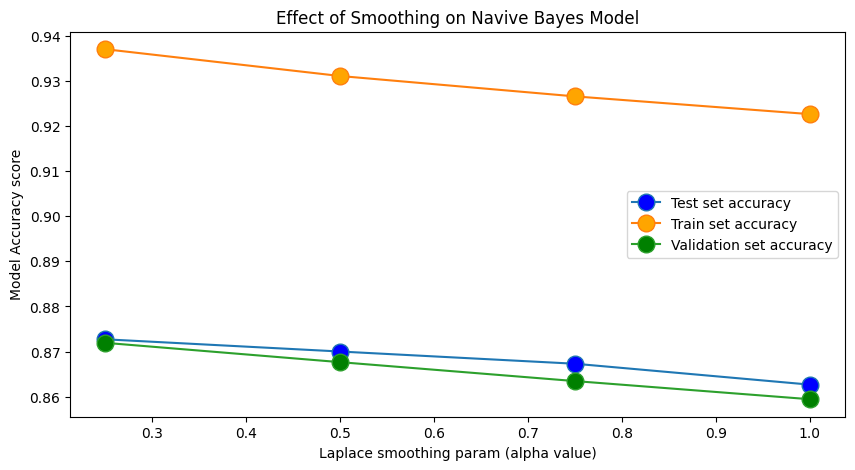

In [18]:
smoothing_params = [0.25, 0.5, 0.75, 1]
train_scores = []
test_scores = []
val_scores = []

for param in smoothing_params:
    mnb_model = MultinomialNB(alpha=param)
    mnb_model.fit(X_train_cv,y_train)
    
    # evaluate accuracy
    test_scores.append(mnb_model.score(X_test_cv, y_test))
    train_scores.append(mnb_model.score(X_train_cv, y_train))
    val_scores.append(mnb_model.score(X_val_cv, y_val))
    

plot = plt.figure(figsize=(10, 5))
plt.plot(smoothing_params, test_scores, marker='o', markerfacecolor='blue', markersize=12, label='Test set accuracy') 
plt.plot(smoothing_params, train_scores, marker='o', markerfacecolor='orange', markersize=12, label='Train set accuracy') 
plt.plot(smoothing_params, val_scores, marker='o', markerfacecolor='green', markersize=12, label='Validation set accuracy') 
plt.xlabel('Laplace smoothing param (alpha value)') 
plt.ylabel('Model Accuracy score') 
plt.legend() 
plt.title('Effect of Smoothing on Navive Bayes Model') 
plt.show() 
plot.savefig('laplace_effect.png', bbox_inches='tight')


##### As observered from the figure above if alpha score is too low, there high chances of overfitting
##### Interestingly, for our dataset, we notice that as the alpha value( probability used for laplace smoothening) both test and train accuracy decreases. This could be because our dataset is rich and has a good representation of all features, so setting alpha too high, might  over-smooth the probabilities, essentially giving too much weight to the smoothing term and not relying enough on the actual counts from the training data. This could lead to a loss of information and a decrease in predictive performance.

### 3. Decision Tree

##### Lets first limit the depth of tree to 4 to visualize how the tree builds

In [19]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(criterion='gini', splitter = 'best',max_depth=4, random_state=42)
decision_tree_model.fit(X_train_cv, y_train)
decision_tree_model_predictions = decision_tree_model.predict(X_test_cv)

# Test model accuracy
train_accuracy = decision_tree_model.score(X_train_cv, y_train)
test_accuracy = decision_tree_model.score(X_test_cv, y_test)

print("Training score:", train_accuracy)
print("Test score:", test_accuracy)

Training score: 0.5817657678644226
Test score: 0.5808874912648497


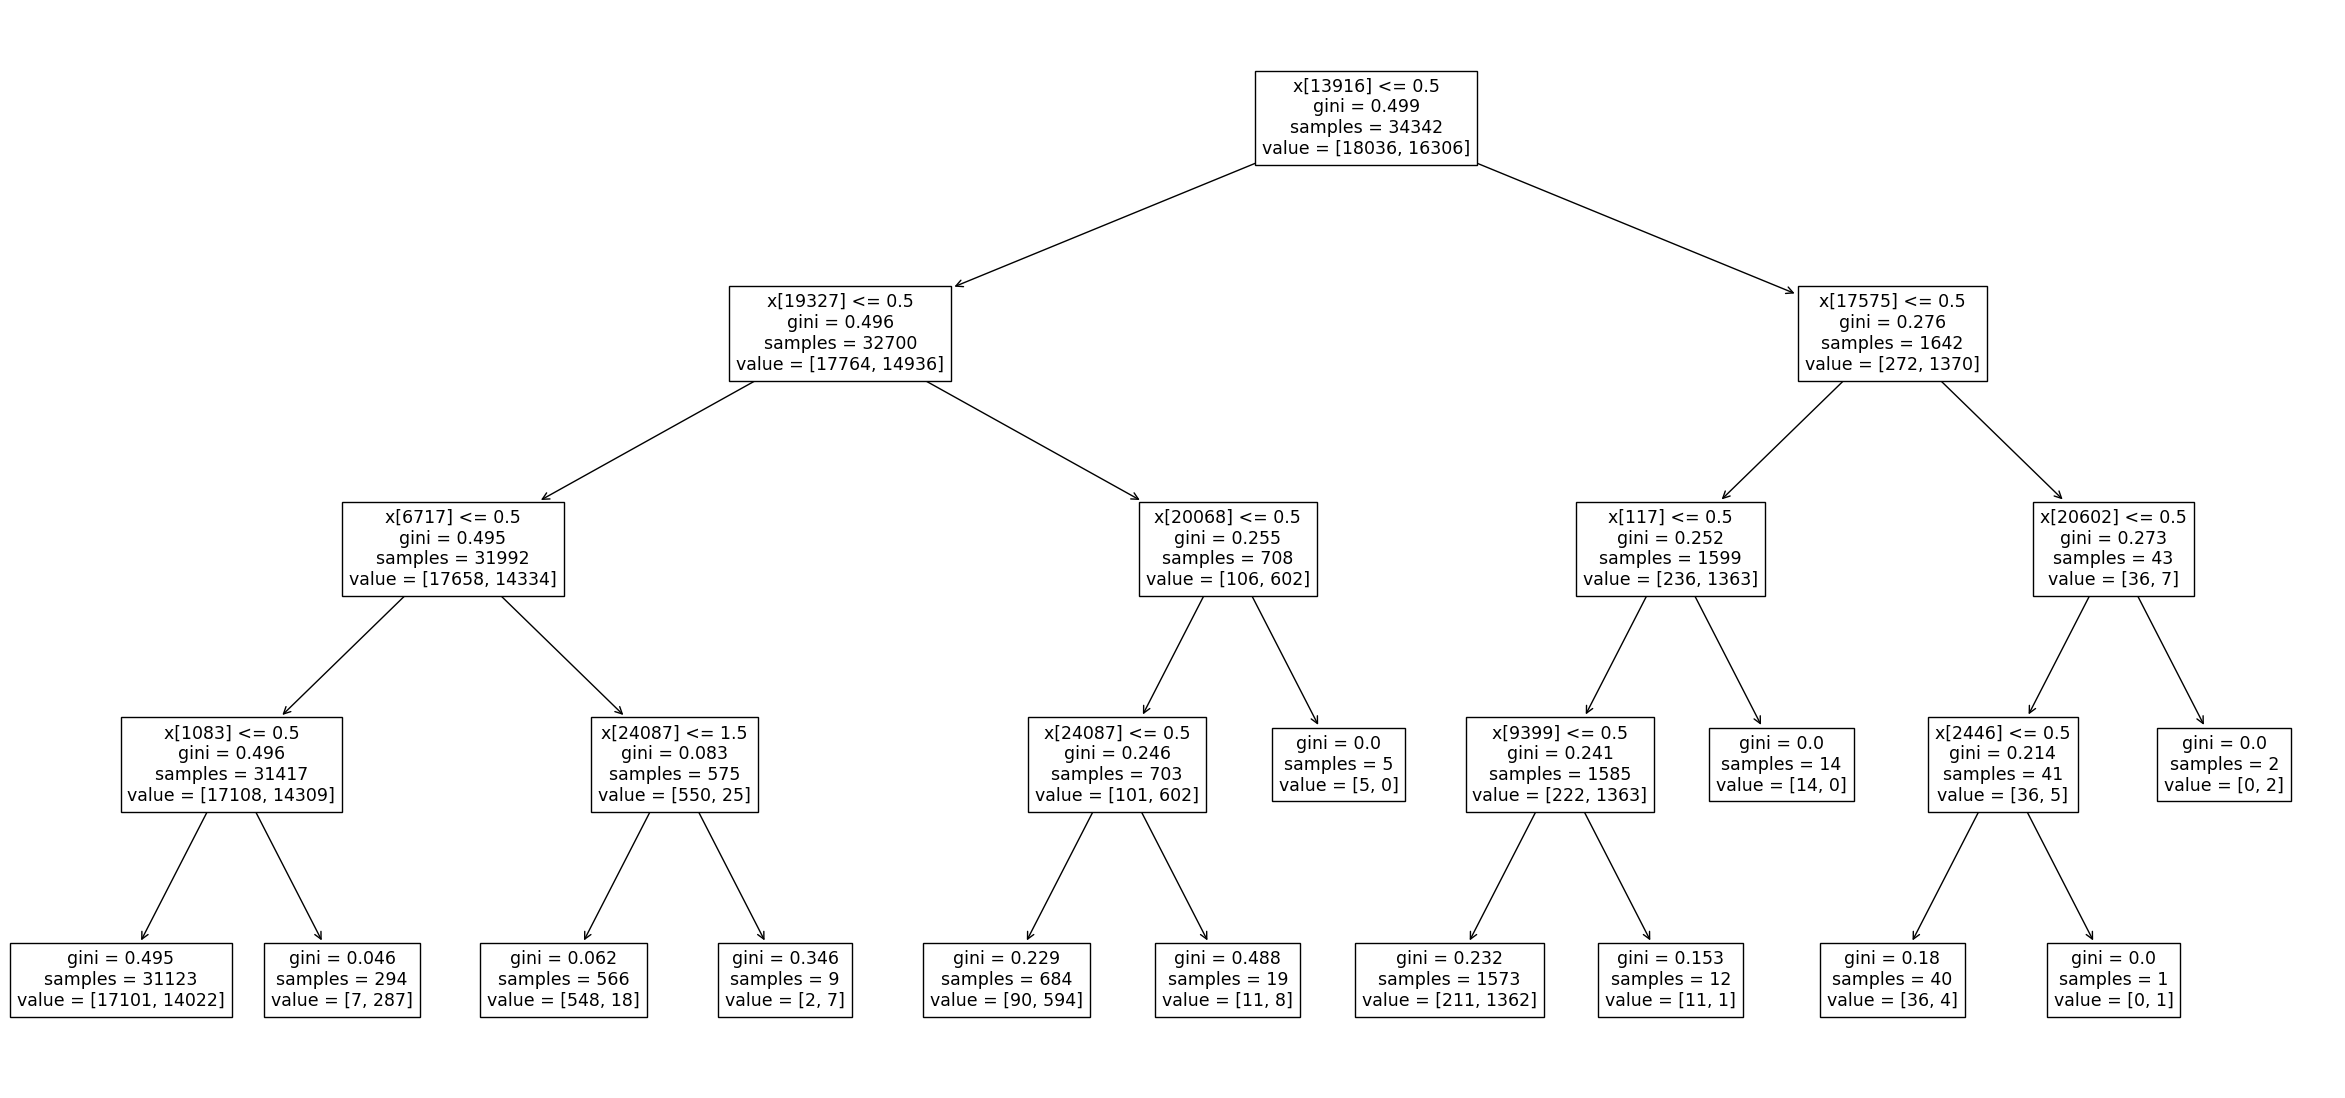

In [20]:
from sklearn import tree
plot = plt.figure(figsize = (30,14))
tree.plot_tree(decision_tree_model)
plt.show()
plot.savefig('decision_tree.png', bbox_inches='tight')

 Depth:50 Training score: 0.7143148331489139
 Depth:50 Test score: 0.6909503843466107
 Depth:75 Training score: 0.7510628385067847
 Depth:75 Test score: 0.7165443745632425
 Depth:100 Training score: 0.7765127249432182
 Depth:100 Test score: 0.7346261355695318
 Depth:250 Training score: 0.8599091491468173
 Depth:250 Test score: 0.7912299091544375
 Depth:500 Training score: 0.9170985964707937
 Depth:500 Test score: 0.8232879105520615


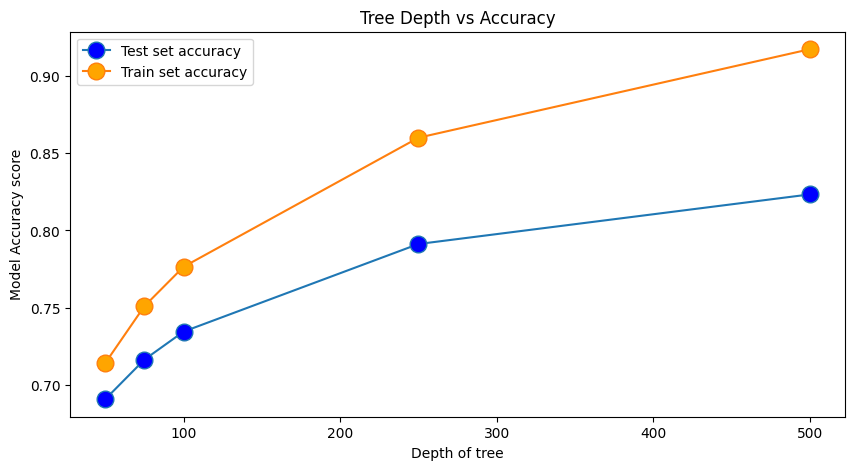

In [21]:
from sklearn.tree import DecisionTreeClassifier
depth = [50,75,100,250,500]
test_score = []
train_score = []
for d in depth:
    decision_tree_model = DecisionTreeClassifier(criterion='gini', splitter = 'best',max_depth=d, random_state=42)
    decision_tree_model.fit(X_train_cv, y_train)
    decision_tree_model_predictions = decision_tree_model.predict(X_test_cv)
    
    # Test model accuracy
    train_accuracy = decision_tree_model.score(X_train_cv, y_train)
    test_accuracy = decision_tree_model.score(X_test_cv, y_test)

    print(f' Depth:{d} Training score: {train_accuracy}')
    print(f' Depth:{d} Test score: {test_accuracy}')
    
    test_score.append(test_accuracy)
    train_score.append(train_accuracy)


plot = plt.figure(figsize=(10, 5))
plt.plot(depth, test_score, marker='o', markerfacecolor='blue', markersize=12, label='Test set accuracy') 
plt.plot(depth, train_score, marker='o', markerfacecolor='orange', markersize=12, label='Train set accuracy') 
plt.xlabel('Depth of tree') 
plt.ylabel('Model Accuracy score') 
plt.legend() 
plt.title('Tree Depth vs Accuracy') 
plt.show() 
plot.savefig('tree_depth.png', bbox_inches='tight')
    

##### Now lets allow the tree to build till we get pure nodes or min sample =2

In [22]:
from sklearn.tree import DecisionTreeClassifier
gini_decision_tree_model = DecisionTreeClassifier(criterion='gini', splitter = 'best', random_state=42)
gini_decision_tree_model.fit(X_train_cv, y_train)
gini_decision_tree_model_predictions = gini_decision_tree_model.predict(X_test_cv)

# Test model accuracy
train_accuracy = gini_decision_tree_model.score(X_train_cv, y_train)
test_accuracy = gini_decision_tree_model.score(X_test_cv, y_test)

print("Training score:", train_accuracy)
print("Test score:", test_accuracy)

Training score: 1.0
Test score: 0.8860062893081762


In [23]:
print("Dept of tree using gini index: ", gini_decision_tree_model.tree_.max_depth)

Dept of tree using gini index:  1742


##### Using entropy to measure quality of split

In [24]:
from sklearn.tree import DecisionTreeClassifier
entropy_decision_tree_model = DecisionTreeClassifier(criterion='entropy', splitter = 'best', random_state=42)
entropy_decision_tree_model.fit(X_train_cv, y_train)
entropy_decision_tree_model_predictions = entropy_decision_tree_model.predict(X_test_cv)

# Test model accuracy
train_accuracy = entropy_decision_tree_model.score(X_train_cv, y_train)
test_accuracy = entropy_decision_tree_model.score(X_test_cv, y_test)

print("Training score:", train_accuracy)
print("Test score:", test_accuracy)

Training score: 1.0
Test score: 0.889412997903564


In [25]:
print("Dept of tree using entropy: ", entropy_decision_tree_model.tree_.max_depth)

Dept of tree using entropy:  1754


In [26]:
decision_tree_predictions = gini_decision_tree_model_predictions

### 4. Sequential Neural Network

##### Neural networks have an internal embedding layer that converts text data into word embedding. It does so by transforming word indices into dense vectors so it can caputre the semantic relation between the words

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Converting input text data into text sequences i.e. sequence of word indices generating using tokenizer.

#Max zize of each word
vocab_size = 10000
# Embedding dimension 
embedding_dim = 200 
# Max length of sentence
max_length = 60
# Unknow word token
oov_tok = '<OOV>'
 
# Create a tokenizer using the training input data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Fit the tokenizer on the input text data to create word-to-index mapping
tokenizer.fit_on_texts(X)

#Convert each train input sentence to a sequqnce of word indices and padding to each sequence
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded_sequences = pad_sequences(train_sequences,maxlen = max_length,padding = 'post')

#Convert each test input sentence to a sequqnce of word indices and padding to each sequence
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded_sequences = pad_sequences(test_sequences,maxlen = max_length,padding = 'post')

#Convert each validation input sentence to a sequqnce of word indices and padding to each sequence
val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded_sequences = pad_sequences(val_sequences,maxlen = max_length,padding = 'post')

#### Lets visualize how text sequences works

In [28]:
# Get the word index from the tokenizer
print("Word to index mapping")
tokenizer.word_index

Word to index mapping


{'<OOV>': 1,
 'new': 2,
 'trump': 3,
 'man': 4,
 'report': 5,
 'us': 6,
 'one': 7,
 'woman': 8,
 'area': 9,
 'says': 10,
 'day': 11,
 'donald': 12,
 'time': 13,
 'like': 14,
 'first': 15,
 'get': 16,
 'trumps': 17,
 'people': 18,
 'house': 19,
 'life': 20,
 'still': 21,
 'white': 22,
 'obama': 23,
 'make': 24,
 'back': 25,
 'women': 26,
 'clinton': 27,
 'could': 28,
 'years': 29,
 'world': 30,
 'family': 31,
 'americans': 32,
 'way': 33,
 'study': 34,
 'would': 35,
 'black': 36,
 'gop': 37,
 'bill': 38,
 'finds': 39,
 'really': 40,
 'american': 41,
 'know': 42,
 'nation': 43,
 'school': 44,
 'police': 45,
 'cant': 46,
 'best': 47,
 'going': 48,
 'show': 49,
 'good': 50,
 'watch': 51,
 'president': 52,
 'death': 53,
 'home': 54,
 'every': 55,
 'video': 56,
 'things': 57,
 'state': 58,
 'last': 59,
 'say': 60,
 'big': 61,
 'parents': 62,
 'love': 63,
 'campaign': 64,
 'year': 65,
 'mom': 66,
 'health': 67,
 'getting': 68,
 'may': 69,
 'kids': 70,
 'hillary': 71,
 'work': 72,
 'gets': 73,

In [29]:
#Sequence creation using word index
# Using the previous wor indices it gen
print("First 2 input senetences: \n",X_train[:2])

print("\nCoresponding sequence of each sentence")
seq= tokenizer.texts_to_sequences(X_train[:2])
print(seq)

print("\nNotice that the sequences are not equal in lenght. That's why we use padding to convert them into equal size sequences as follows:")
print(pad_sequences(seq,maxlen = max_length,padding = 'post'))


First 2 input senetences: 
 ['briefly talk honestly weddings' 'friends grandma give hug']

Coresponding sequence of each sentence
[[2883, 246, 5696, 4813], [132, 873, 159, 3135]]

Notice that the sequences are not equal in lenght. That's why we use padding to convert them into equal size sequences as follows:
[[2883  246 5696 4813    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [ 132  873  159 3135    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


### Model Development

##### Lets start with simple model with just 1 hidden layer

In [30]:
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,GlobalAveragePooling1D, GlobalMaxPool1D
from tensorflow.keras import Sequential

# Lets start with neural with just 1 hidden layer and relu activation function and output with sigmoid function
snn_model1 = Sequential([
    #Embedding layer
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    # GlobalMaxPooling layer to extract relevant features
    GlobalAveragePooling1D(),
    # Hidden layer 1
    Dense(24, activation='relu'),
    # Output layer
    Dense(1, activation='sigmoid')
])
# Compile the model with cross entropy loss function, optimizer, and evaluation metrics
snn_model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

snn_model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 200)           2000000   
                                                                 
 global_average_pooling1d (  (None, 200)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                4824      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2004849 (7.65 MB)
Trainable params: 2004849 (7.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Set the number of training epochs
num_epochs = 5
 
# Fit the model to the training data and validate on the validation data
history = snn_model1.fit(
    train_padded_sequences, y_train,
    epochs=num_epochs,
    validation_data=(val_padded_sequences, y_val)
)

Epoch 1/5


1074/1074 [==============================] - 36s 32ms/step - loss: 0.5397 - accuracy: 0.7037 - val_loss: 0.4025 - val_accuracy: 0.8055
Epoch 2/5
1074/1074 [==============================] - 35s 32ms/step - loss: 0.3114 - accuracy: 0.8677 - val_loss: 0.3370 - val_accuracy: 0.8524
Epoch 3/5
1074/1074 [==============================] - 34s 32ms/step - loss: 0.2456 - accuracy: 0.9002 - val_loss: 0.3308 - val_accuracy: 0.8624
Epoch 4/5
1074/1074 [==============================] - 35s 32ms/step - loss: 0.2130 - accuracy: 0.9146 - val_loss: 0.3541 - val_accuracy: 0.8592
Epoch 5/5
1074/1074 [==============================] - 39s 36ms/step - loss: 0.1891 - accuracy: 0.9248 - val_loss: 0.3393 - val_accuracy: 0.8767


#### Now let's add more layers and observe it effects the accuracy

In [32]:
snn_model2 = Sequential([
    #Embedding layer
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    # GlobalMaxPooling layer to extract relevant features
    GlobalMaxPool1D(),
    # Hidden layer 1 with 40 neurons and ReLU activation
    Dense(30, activation='relu'), 
    # Dropout layer to prevent overfitting
    Dropout(0.5),
 
    # Hidden layer 2 with 20 neurons and ReLU activation
    Dense(20, activation='relu'),
    # Dropout layer to prevent overfitting
    Dropout(0.3),

    # Output layer
    Dense(1, activation='sigmoid') 
])
# Compile the model with cross entropy loss function, optimizer, and evaluation metrics
snn_model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

snn_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 200)           2000000   
                                                                 
 global_max_pooling1d (Glob  (None, 200)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 30)                6030      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                620       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                      

In [58]:
# Set the number of training epochs
num_epochs = 5
 
# Fit the model to the training data and validate on the validation data
history = snn_model2.fit(
    train_padded_sequences, y_train,
    epochs=num_epochs,
    validation_data=(val_padded_sequences, y_val)
)

Epoch 1/5
1074/1074 [==============================] - 43s 40ms/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.5577 - val_accuracy: 0.9202
Epoch 2/5
1074/1074 [==============================] - 37s 34ms/step - loss: 0.0065 - accuracy: 0.9978 - val_loss: 0.6250 - val_accuracy: 0.9232
Epoch 3/5
1074/1074 [==============================] - 34s 32ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.6930 - val_accuracy: 0.9236
Epoch 4/5
1074/1074 [==============================] - 35s 32ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.7221 - val_accuracy: 0.9210
Epoch 5/5
1074/1074 [==============================] - 36s 33ms/step - loss: 0.0057 - accuracy: 0.9979 - val_loss: 0.6750 - val_accuracy: 0.9205


In [34]:
snn_model3 = Sequential([
    #Embedding layer
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    # GlobalMaxPooling layer to extract relevant features
    GlobalMaxPool1D(),
    # Hidden layer 1 with 40 neurons and ReLU activation
    Dense(40, activation='relu'), 
    # Dropout layer to prevent overfitting
    Dropout(0.2),
 
    # Hidden layer 2 with 20 neurons and ReLU activation
    Dense(20, activation='relu'),
    # Dropout layer to prevent overfitting
    Dropout(0.2),
 
    # Hidden layer 3 with 10 neurons and ReLU activation
    Dense(10, activation='relu'),
    # Dropout layer to prevent overfitting
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid') 
])

# Compile the model with cross entropy loss function, optimizer, and evaluation metrics
snn_model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

snn_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 200)           2000000   
                                                                 
 global_max_pooling1d_1 (Gl  (None, 200)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 40)                8040      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                820       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                      

In [57]:
# Set the number of training epochs
num_epochs = 5
 
# Fit the model to the training data and validate on the validation data
history = snn_model3.fit(
    train_padded_sequences, y_train,
    epochs=num_epochs,
    validation_data=(val_padded_sequences, y_val)
)

Epoch 1/5
1074/1074 [==============================] - 36s 34ms/step - loss: 0.0095 - accuracy: 0.9976 - val_loss: 0.6252 - val_accuracy: 0.9193
Epoch 2/5
1074/1074 [==============================] - 33s 31ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.7201 - val_accuracy: 0.9195
Epoch 3/5
1074/1074 [==============================] - 37s 35ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.8122 - val_accuracy: 0.9164
Epoch 4/5
1074/1074 [==============================] - 40s 37ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.8418 - val_accuracy: 0.9202
Epoch 5/5
1074/1074 [==============================] - 35s 32ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.7738 - val_accuracy: 0.9216


#### Now lets increase the number of epoch's and oberserve how its effects the model

In [36]:
# Set the number of training epochs
num_epochs = 15

snn_model4 =  Sequential([
    #Embedding layer
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    # GlobalMaxPooling layer to extract relevant features
    GlobalAveragePooling1D(),
    # Hidden layer 1
    Dense(24, activation='relu'),
    # Output layer
    Dense(1, activation='sigmoid')
])
snn_model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Fit the model to the training data and validate on the validation data
history = snn_model4.fit(
    train_padded_sequences, y_train,
    epochs=num_epochs,
    validation_data=(val_padded_sequences, y_val)
)

Epoch 1/15
1074/1074 [==============================] - 38s 34ms/step - loss: 0.5265 - accuracy: 0.7182 - val_loss: 0.3772 - val_accuracy: 0.8282
Epoch 2/15
1074/1074 [==============================] - 37s 34ms/step - loss: 0.3072 - accuracy: 0.8686 - val_loss: 0.3340 - val_accuracy: 0.8566
Epoch 3/15
1074/1074 [==============================] - 35s 33ms/step - loss: 0.2438 - accuracy: 0.9010 - val_loss: 0.3232 - val_accuracy: 0.8684
Epoch 4/15
1074/1074 [==============================] - 33s 31ms/step - loss: 0.2099 - accuracy: 0.9159 - val_loss: 0.3241 - val_accuracy: 0.8751
Epoch 5/15
1074/1074 [==============================] - 33s 31ms/step - loss: 0.1857 - accuracy: 0.9296 - val_loss: 0.3278 - val_accuracy: 0.8779
Epoch 6/15
1074/1074 [==============================] - 38s 36ms/step - loss: 0.1689 - accuracy: 0.9362 - val_loss: 0.3287 - val_accuracy: 0.8829
Epoch 7/15
1074/1074 [==============================] - 32s 30ms/step - loss: 0.1564 - accuracy: 0.9415 - val_loss: 0.3438 -

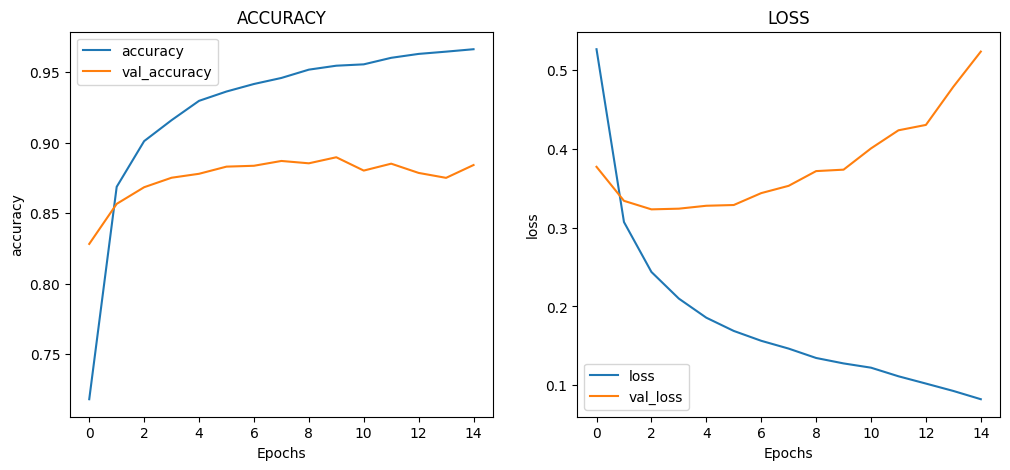

In [37]:
def plot_graphs(history, metric,axis):
  axis.plot(history.history[metric])
  axis.plot(history.history['val_'+metric])
  axis.set_xlabel("Epochs")
  axis.set_ylabel(metric)
  axis.set_title(metric.upper())
  axis.legend([metric, 'val_'+metric])
 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_graphs(history, "accuracy",ax1)
plot_graphs(history, "loss",ax2)

plt.show()
fig.savefig('epoch_effect.png', bbox_inches='tight')

In [38]:

#evaluating loss and accuray of the model
loss, accuracy = snn_model3.evaluate(test_padded_sequences,y_test)
print(f'Test accuracy :{round(accuracy*100,2)}%')

358/358 [==============================] - 2s 4ms/step - loss: 0.5497 - accuracy: 0.9188
Test accuracy :91.88%


In [39]:

#predicting the model 
snn_model_predictions = snn_model3.predict(test_padded_sequences)
snn_model_predictions = [1 if prob >= 0.5 else 0 for prob in snn_model_predictions]


358/358 [==============================] - 2s 4ms/step


## Step 4: Evaluate and Compare the models

In [40]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score, classification_report, confusion_matrix

In [41]:
import seaborn as sns
def plot_bar_graph(x, y, data,graph_name):
    plot = plt.figure(figsize = (16,10))
    ax=sns.barplot(x=x, y=y, data=df)
    # Add values above bars
    for i, v in enumerate(y):
       ax.text(i, v+0.01, str(v), ha='center')

    plt.show()
    plot.savefig(graph_name+'.png', bbox_inches='tight')
    

### 1. Accuracy

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


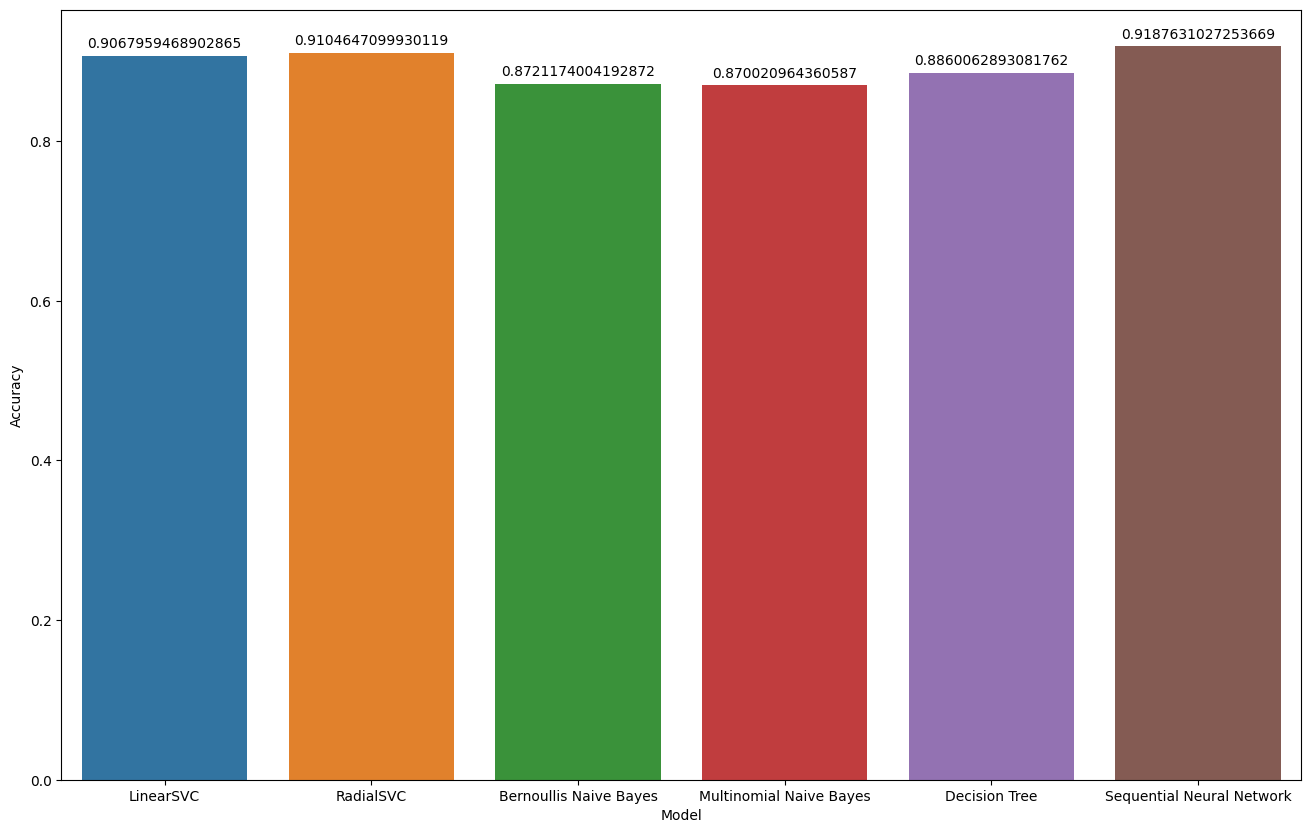

In [59]:
acc_table = {
    'LinearSVC' : accuracy_score(linear_sv_model_predictions,y_test),
    'RadialSVC' : accuracy_score(rbf_sv_model_predictions,y_test),
    'Bernoullis Naive Bayes' : accuracy_score(nb_model_predictions,y_test),
    'Multinomial Naive Bayes': accuracy_score(mnb_model_predictions,y_test),
    'Decision Tree': accuracy_score(decision_tree_predictions,y_test),
    'Sequential Neural Network': accuracy_score(snn_model_predictions,y_test),
}

metric_data = pd.DataFrame(acc_table.items(),columns = ['Model','Accuracy'])

# Plot the accuracies
plot_bar_graph(x=metric_data['Model'], y=metric_data['Accuracy'], data=metric_data, graph_name='accuracy_metric')


### 2. Precision

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


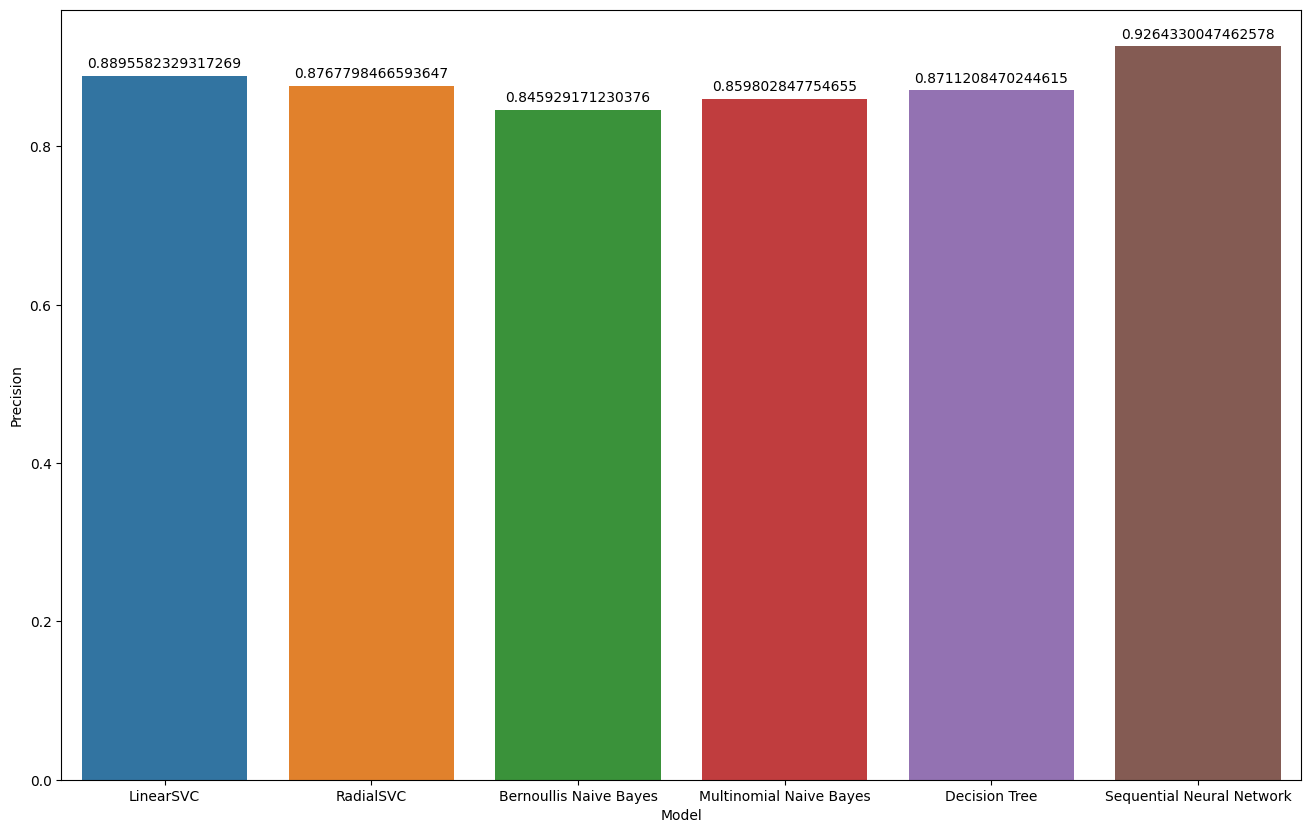

In [60]:
precision_table = {
    'LinearSVC' : precision_score(linear_sv_model_predictions,y_test),
    'RadialSVC' : precision_score(rbf_sv_model_predictions,y_test),
    'Bernoullis Naive Bayes' : precision_score(nb_model_predictions,y_test),
    'Multinomial Naive Bayes': precision_score(mnb_model_predictions,y_test),
    'Decision Tree': precision_score(decision_tree_predictions,y_test),
    'Sequential Neural Network': precision_score(snn_model_predictions,y_test),
}

metric_data = pd.DataFrame(precision_table.items(),columns = ['Model','Precision'])

# Plot the accuracies
plot_bar_graph(x=metric_data['Model'], y=metric_data['Precision'], data=metric_data, graph_name='precision_metric')


### 3. Recall Score

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


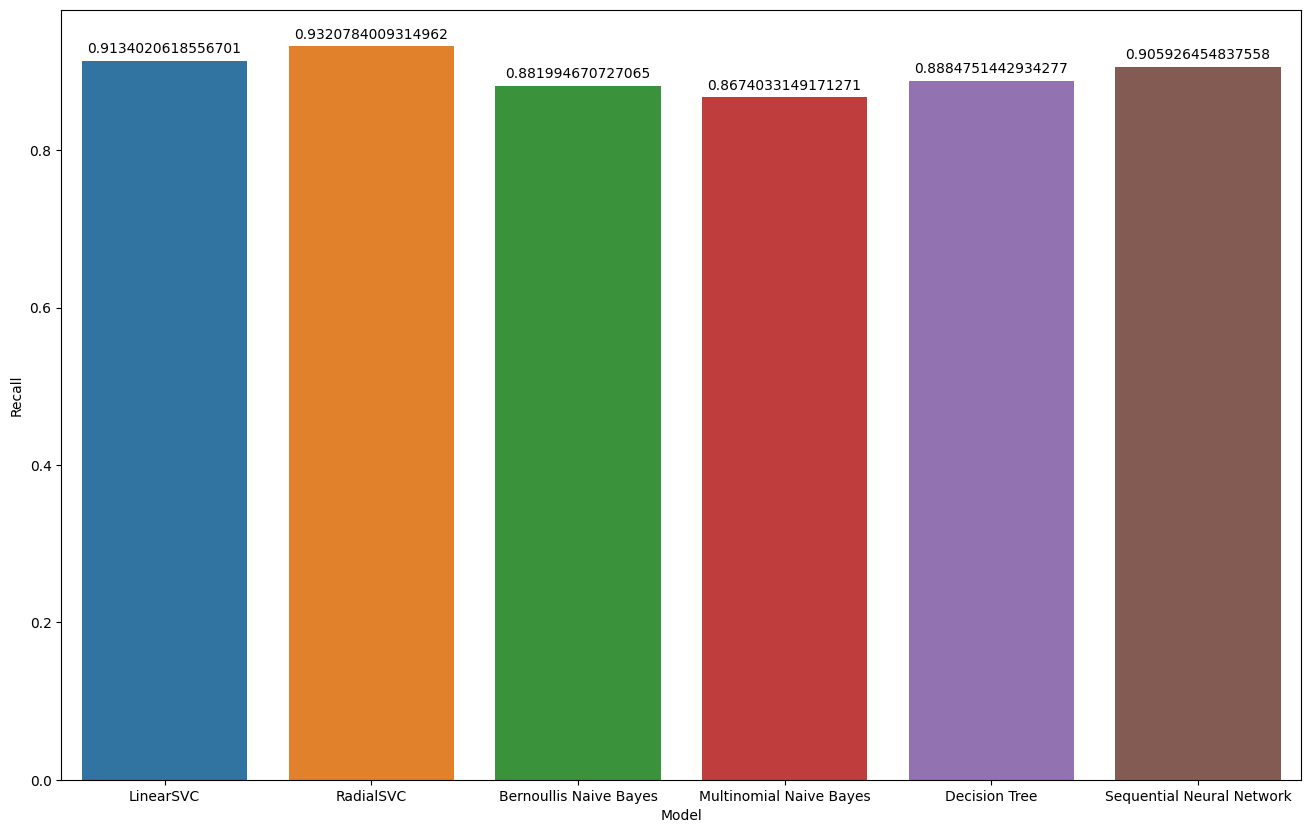

In [61]:
recall_table = {
    'LinearSVC' : recall_score(linear_sv_model_predictions,y_test),
    'RadialSVC' : recall_score(rbf_sv_model_predictions,y_test),
    'Bernoullis Naive Bayes' : recall_score(nb_model_predictions,y_test),
    'Multinomial Naive Bayes': recall_score(mnb_model_predictions,y_test),
    'Decision Tree': recall_score(decision_tree_predictions,y_test),
    'Sequential Neural Network': recall_score(snn_model_predictions,y_test),
}

metric_data = pd.DataFrame(recall_table.items(),columns = ['Model','Recall'])

# Plot the accuracies
plot_bar_graph(x=metric_data['Model'], y=metric_data['Recall'], data=metric_data, graph_name='recall_metric')

### 4. F1-Score

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


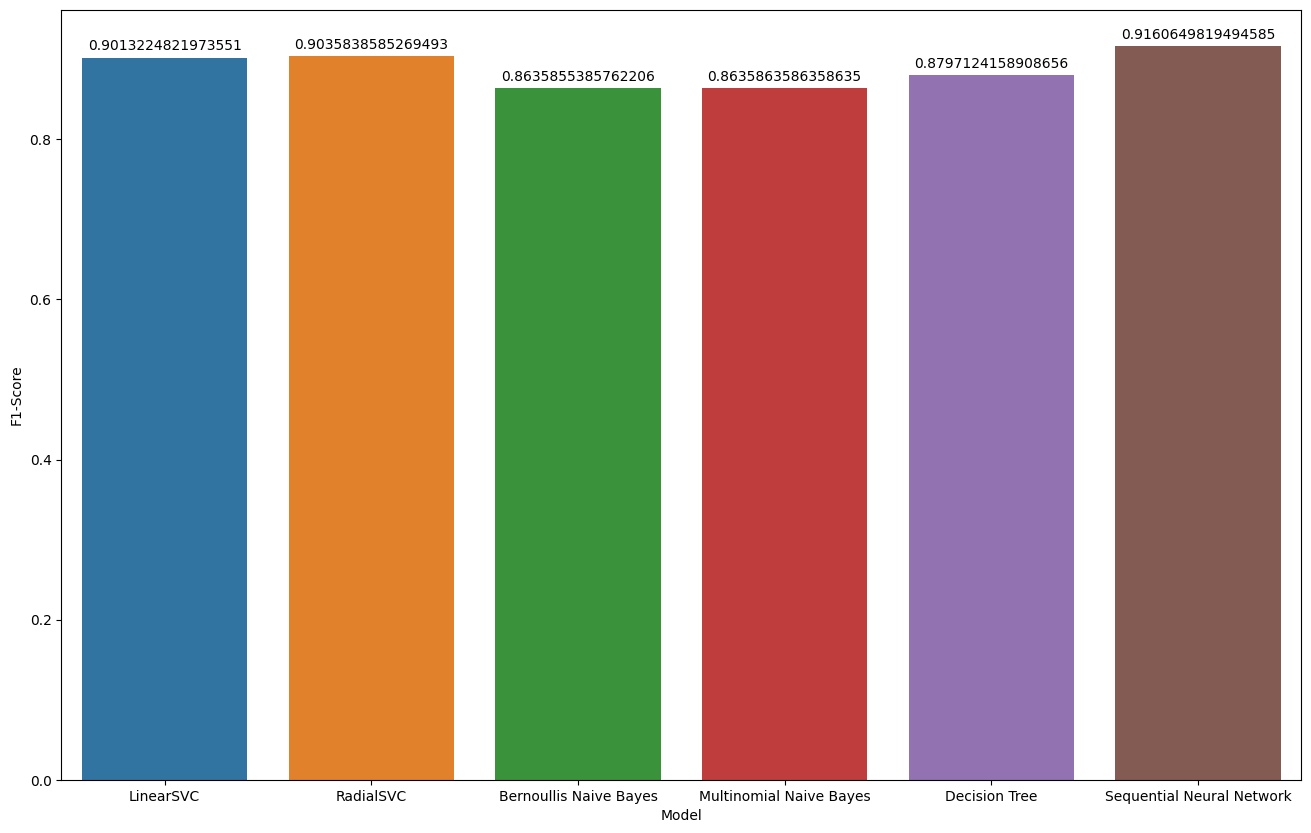

In [62]:
f1_table = {
    'LinearSVC' : f1_score(linear_sv_model_predictions,y_test),
    'RadialSVC' : f1_score(rbf_sv_model_predictions,y_test),
    'Bernoullis Naive Bayes' : f1_score(nb_model_predictions,y_test),
    'Multinomial Naive Bayes': f1_score(mnb_model_predictions,y_test),
    'Decision Tree': f1_score(decision_tree_predictions,y_test),
    'Sequential Neural Network': f1_score(snn_model_predictions,y_test),
}

metric_data = pd.DataFrame(f1_table.items(),columns = ['Model','F1-Score'])

# Plot the accuracies
plot_bar_graph(x=metric_data['Model'], y=metric_data['F1-Score'], data=metric_data, graph_name='f1_metric')

### 5. Precision-Recall Curve

Linear SVC AUC score:  0.9279039768835656
Radial SVC AUC score:  0.9339102558709022
Bernoullis Naive Bayes AUC score:  0.9008242550108659
Multinomial Naive Bayes AUC score:  0.8971460582750943
Decision Tree AUC score:  0.9106330760223268
Sequential Neural Network AUC score:  0.9337810575347449


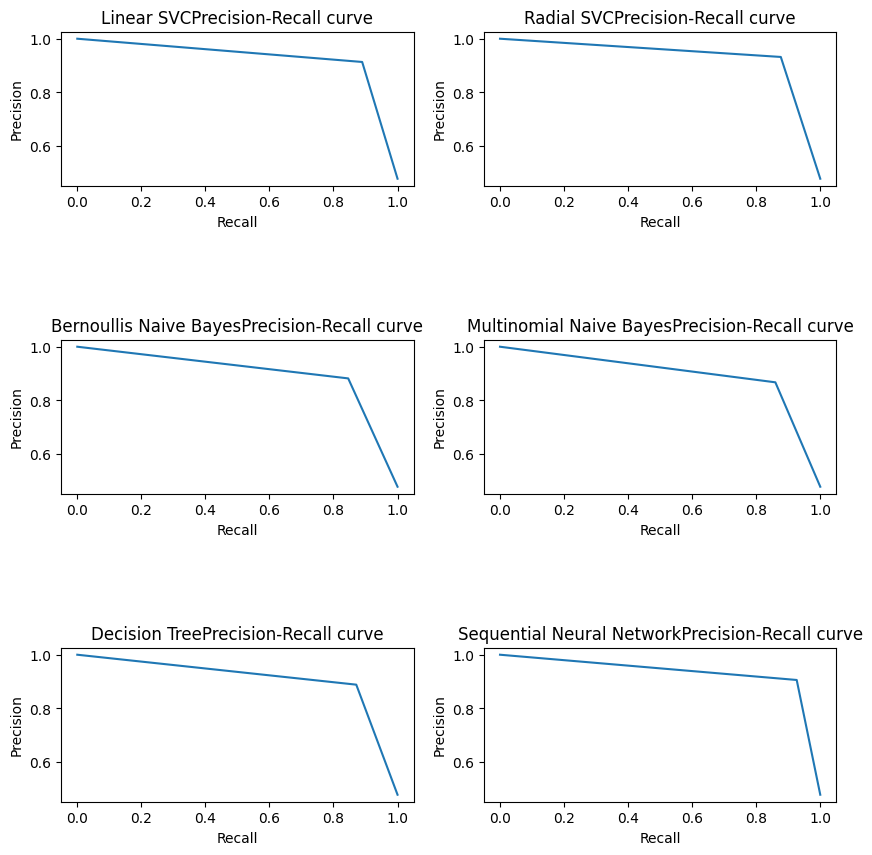

In [63]:
from sklearn.metrics import precision_recall_curve, auc
def plot_sklearn_precision_recall_curve(y_pred,y_test,ax, model):
   
    p, r, thresholds = precision_recall_curve(y_test, y_pred)
    ax.plot(r, p)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(model + 'Precision-Recall curve')
    print(model+' AUC score: ', auc(r, p))

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust( hspace=1)
(ax1,ax2,ax3,ax4,ax5,ax6) = axes.flatten()
plot_sklearn_precision_recall_curve(linear_sv_model_predictions,y_test,ax1, "Linear SVC")
plot_sklearn_precision_recall_curve(rbf_sv_model_predictions,y_test,ax2,"Radial SVC")
plot_sklearn_precision_recall_curve(nb_model_predictions,y_test,ax3, "Bernoullis Naive Bayes")
plot_sklearn_precision_recall_curve(mnb_model_predictions,y_test,ax4, "Multinomial Naive Bayes")
plot_sklearn_precision_recall_curve(decision_tree_predictions,y_test,ax5, "Decision Tree")
plot_sklearn_precision_recall_curve(snn_model_predictions,y_test,ax6, "Sequential Neural Network")

plt.show()
fig.savefig('precision_recall.png', bbox_inches='tight')

### 6. Confusion Matrix

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_pred,y_test, model):
   
    conf_matrix = confusion_matrix(y_test, y_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["Not Sarcastic", "Sarcastic"])
    cm = cm_display.plot()
    plt.title(model+ " Confusion Matrix")
    plt.show()
    cm.figure_.savefig(model+'_confusion_matrix.png')



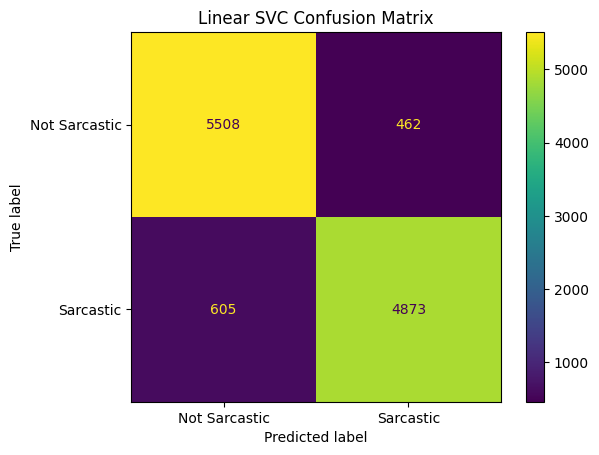

In [65]:
plot_confusion_matrix(linear_sv_model_predictions,y_test, "Linear SVC")

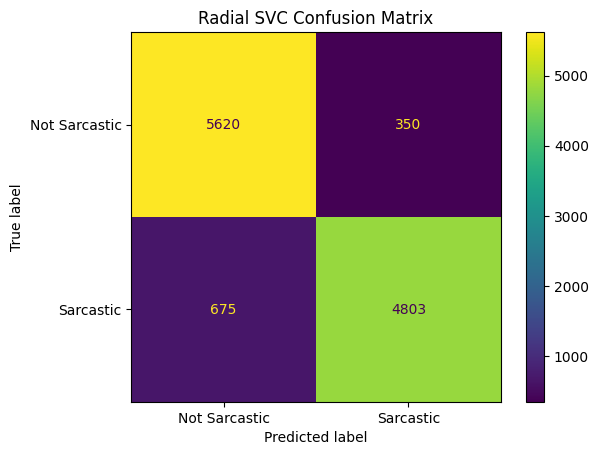

In [66]:
plot_confusion_matrix(rbf_sv_model_predictions,y_test,"Radial SVC")

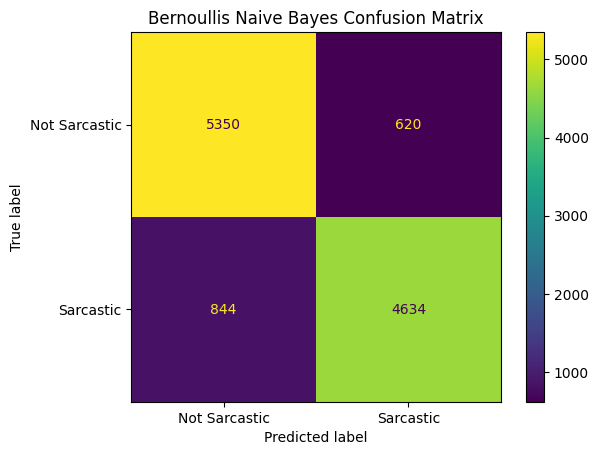

In [67]:
plot_confusion_matrix(nb_model_predictions,y_test, "Bernoullis Naive Bayes")

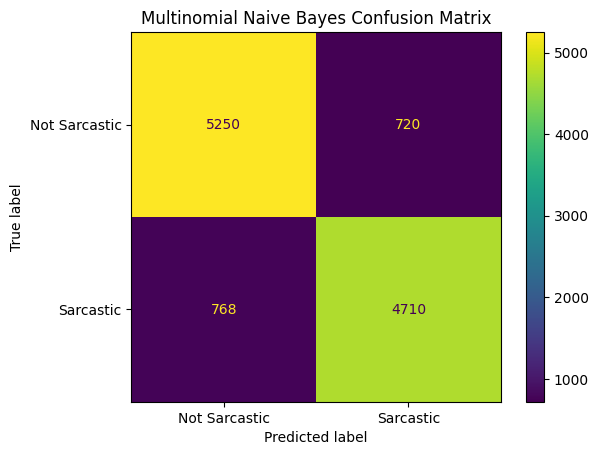

In [68]:
plot_confusion_matrix(mnb_model_predictions,y_test, "Multinomial Naive Bayes")

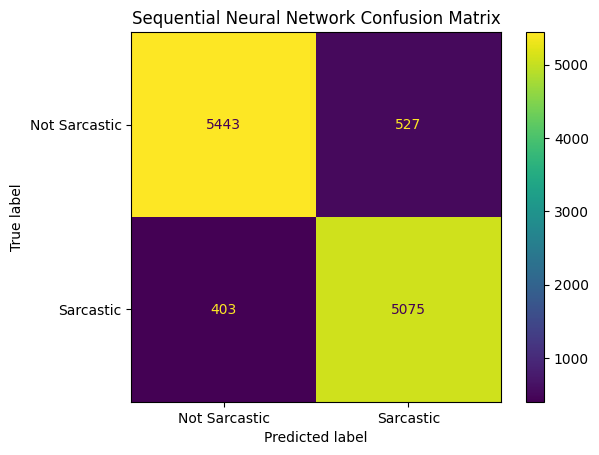

In [69]:
plot_confusion_matrix(snn_model_predictions,y_test, "Sequential Neural Network")


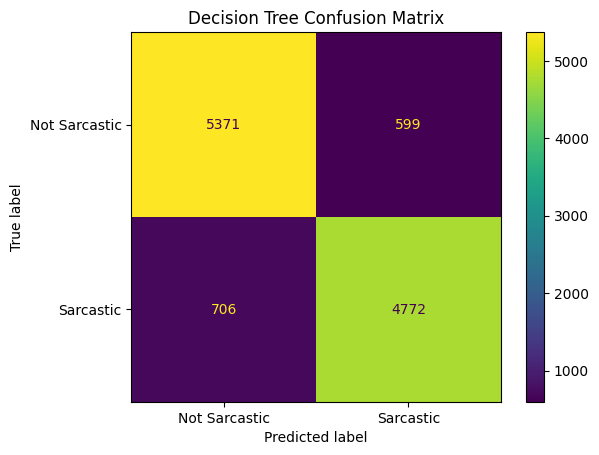

In [70]:
plot_confusion_matrix(decision_tree_predictions,y_test, "Decision Tree")

## 5. Predict the output

##### sample inputs
###### hello how are you?
###### Machine learning is easy
###### Kids Make Nutritious Snacks
###### Juvenile Court to Try Shooting Defendant
###### Enraged Cow Injures Farmer with Ax
###### Red Tape Holds Up New Bridges
###### Man Struck By Lightning Faces Battery Charge

In [73]:
while True:
	user_input = input(
		"Enter any sentence for prediction or press 1 to exit: ")

	if user_input.lower() == '1':
		break

	# Clean the data and convert into feature vector
	cleaned_data = clean_data(user_input)
    # Convert data to text sequences
	tokenized_input = tokenizer.texts_to_sequences([cleaned_data])
	padded_input = pad_sequences(tokenized_input, maxlen=max_length, padding='post')

	# Predict sarcasm
	prediction = snn_model3.predict(padded_input)

	# Print the prediction result
	if prediction >= 0.5:
		print(f"Sarcastic")
	else:
		print(f"Not Sarcastic")


Enter any sentence for prediction or press 1 to exit:  hello how are you?


1/1 [==============================] - 0s 28ms/step
Not Sarcastic


Enter any sentence for prediction or press 1 to exit:  Machine learning is easy


1/1 [==============================] - 0s 23ms/step
Not Sarcastic


Enter any sentence for prediction or press 1 to exit:  Kids Make Nutritious Snacks


1/1 [==============================] - 0s 29ms/step
Not Sarcastic


Enter any sentence for prediction or press 1 to exit:  Juvenile Court to Try Shooting Defendant


1/1 [==============================] - 0s 24ms/step
Sarcastic


Enter any sentence for prediction or press 1 to exit:  Enraged Cow Injures Farmer with Ax


1/1 [==============================] - 0s 25ms/step
Sarcastic


Enter any sentence for prediction or press 1 to exit:  Red Tape Holds Up New Bridges


1/1 [==============================] - 0s 24ms/step
Sarcastic


Enter any sentence for prediction or press 1 to exit:  Man Struck By Lightning Faces Battery Charge


1/1 [==============================] - 0s 23ms/step
Not Sarcastic


Enter any sentence for prediction or press 1 to exit:  1
